# Classification

## Objectives

*  Fit and evaluate a classification model to predict if a prospect will churn or not.

## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot



---

# Change working directory

Change the working directory from its current folder to its parent folder


In [31]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Film_Hit_prediction'

Make the parent of the current directory the new current directory.


In [32]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [33]:
current_dir = os.getcwd()
current_dir

'/workspace'

---

# Load Data 

Load Data

In [34]:
import pandas as pd
import pickle

# Load the splits for modeling
X_train = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_train.pkl')
X_test = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_test.pkl')
y_train = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_train.pkl')
y_test = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_test.pkl')


print("Dataset shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Dataset shapes:
X_train shape: (3284, 270)
y_train shape: (3284,)
X_test shape: (813, 270)
y_test shape: (813,)


In [35]:
print("Current split ratio:")
print(f"Training samples: {X_train.shape[0]} ({X_train.shape[0]/(X_train.shape[0] + X_test.shape[0]):.2%})")
print(f"Test samples: {X_test.shape[0]} ({X_test.shape[0]/(X_train.shape[0] + X_test.shape[0]):.2%})")

Current split ratio:
Training samples: 3284 (80.16%)
Test samples: 813 (19.84%)


---

# Step 2: ML Pipeline with all data

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [36]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler

# Define models

models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'solver': ['auto', 'svd', 'cholesky']
        }
    },
    'Lasso': {
        'model': Lasso(random_state=42),  
        'params': {
            'alpha': [0.1 ],  
            'max_iter': [500],
            'tol': [0.1], 
            'selection': ['cyclic'],  
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'n_jobs': [-1]
        }
    },
 
}


# Set up and train model

In [37]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib

results = {}
best_models = {}

for name, model_info in models.items():
    print(f"\n{'='*50}")
    print(f"\nTraining {name}...")

    # GridSearchCV performs the hyperparameter optimization
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs= 1 ,
        verbose=2
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train.ravel())
    best_models[name] = grid_search.best_estimator_




Training Linear Regression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   1.0s


Training Ridge...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ............................alpha=0.01, solver=auto; total time=   0.3s
[CV] END ............................alpha=0.01, solver=auto; total time=   0.5s
[CV] END ............................alpha=0.01, solver=auto; total time=   0.5s
[CV] END .............................alpha=0.01, solver=svd; total time=   1.1s
[CV] END .............................alpha=0.01, solver=svd; total time=   1.3s
[CV] END .............................alpha=0.01, solver=svd; total time=   0.9s
[CV] END ........................alpha=0.01, solver=cholesky; total time=   0.4s
[CV] END .........

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.253091731805863e+18, tolerance: 5.67584574577462e+18
  model = cd_fast.enet_coordinate_descent(


[CV] END .alpha=0.1, max_iter=500, selection=cyclic, tol=0.1; total time=   5.0s


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.153800904535568e+18, tolerance: 6.982214786800402e+18
  model = cd_fast.enet_coordinate_descent(


[CV] END .alpha=0.1, max_iter=500, selection=cyclic, tol=0.1; total time=   5.2s


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.856304036011959e+18, tolerance: 6.580600584278111e+18
  model = cd_fast.enet_coordinate_descent(


[CV] END .alpha=0.1, max_iter=500, selection=cyclic, tol=0.1; total time=   5.0s


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.207138379034676e+19, tolerance: 9.619486165716603e+18
  model = cd_fast.enet_coordinate_descent(




Training Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   1.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   1.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   1.8s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.9s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.9s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.8s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200, n_jobs=-1; total time

# Evaluate Performance

In [38]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib


for name, model in best_models.items():
    print(f"\nTraining {name}...")

     # Make predictions
    y_pred = model.predict(X_test)
    
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2,
        'Best Parameters': grid_search.best_params_
    }
    
    # Print results
    print(f"\nResults for {name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    print(f"Best Parameters: {grid_search.best_params_}")


Training Linear Regression...

Results for Linear Regression:
RMSE: 99053175.73
R2 Score: 0.66
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1}

Training Ridge...

Results for Ridge:
RMSE: 98681577.29
R2 Score: 0.66
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1}

Training Lasso...

Results for Lasso:
RMSE: 99063624.55
R2 Score: 0.66
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1}

Training Random Forest...

Results for Random Forest:
RMSE: 78861507.03
R2 Score: 0.78
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1}


# Save Best Performing Model

In [39]:
import os
import joblib

# 1. First identify the best model
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = best_models[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"Best model RMSE: {results[best_model_name]['RMSE']:.2f}")

# 2. Set up the save directory
save_dir = '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models'
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

# 3. Create the filename with model name and date
from datetime import datetime
current_date = datetime.now().strftime("%Y%m%d")
model_filename = f'film_revenue_model_{best_model_name}_{current_date}.joblib'
full_path = os.path.join(save_dir, model_filename)

# 4. Save the model
joblib.dump(best_model, full_path)

print(f"\nBest model saved as: {model_filename}")
print("Model and scalers saved successfully!")
print("Best model saved successfully!")



Best performing model: Random Forest
Best model RMSE: 78861507.03

Best model saved as: film_revenue_model_Random Forest_20250115.joblib
Model and scalers saved successfully!
Best model saved successfully!


## Assess feature importance

Loaded model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Top 10 Most Important Features:
                                    Feature  Importance
102                              popularity    0.335984
201                                  budget    0.325247
5                         budget_per_minute    0.084827
22                                  runtime    0.030798
169  crew_Producer_James Cameron_pop_weight    0.026265
62              crew_Producer_James Cameron    0.022754
180                               Adventure    0.011247
56                     other_producer_count    0.010556
45                        other_actor_count    0.010382
196            cast_Frank Welker_pop_weight    0.005746


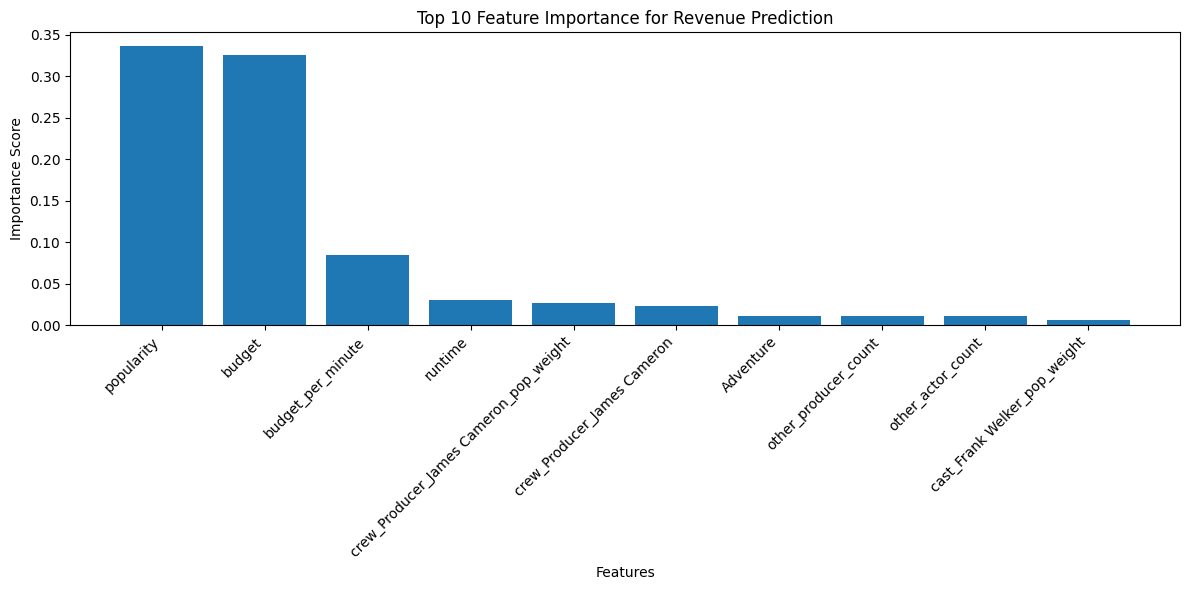

In [40]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved Random Forest model
model_path = '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/film_revenue_model_Random Forest_20250115.joblib'
loaded_model = joblib.load(model_path)

print("Loaded model type:", type(loaded_model))


# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': loaded_model.feature_importances_
})

# Sort features by importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot the top 10 feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance for Revenue Prediction')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


# Prediction Model


Create a function to make predictions for new movies based on parameters:
-  budget (float): Movie budget in dollars
- language (str): Original language (e.g., 'en' for English)
- genres (list): List of genres (e.g., ['Action', 'Adventure'])
    
 Returns:
- float: Predicted revenue and profit

New model

In [61]:
import joblib
import pickle
import pandas as pd
import numpy as np
import traceback

def predict_movie_revenue(budget, runtime, genres, language, production_company, 
                          production_country, actor1, actor2, crew_director, 
                          crew_writer, crew_producer):
    try:
        print("Loading models and data...")
        
        # Load the trained model
        model = joblib.load('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/film_revenue_model_Random Forest_20250115.joblib')
        
        # Load the saved transformation data
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/full_transformation_data.pkl', 'rb') as f:
            transform_data = pickle.load(f)

        # Load the feature scaler separately
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/feature_scaler.pkl', 'rb') as f:
            feature_scaler = pickle.load(f)

        # Extract components from transform_data
        numeric_cols = [col for col in transform_data['numeric_cols'] if col != 'revenue']
        all_features = [col for col in transform_data['all_features'] if col != 'revenue']


        # Initialize features with zero values for all columns
        features = {col: 0 for col in all_features}

        # Process numeric features
        features['budget'] = budget
        features['runtime'] = runtime
        features['budget_per_minute'] = budget / runtime if runtime > 0 else 0
        features['popularity'] = 0 

        # Process genres
        for genre in transform_data['genre_columns']:
            features[genre] = 1 if genre in genres else 0

        # Encode language (assuming LabelEncoder was used)
        language_encoder = transform_data['encoders_and_filters']['language_encoder']
        features['language_encoded'] = language_encoder.transform([language])[0] if language in language_encoder.classes_ else 0

        # Load top actors, directors, writers, and producers data
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/top_revenue_actors.pkl', 'rb') as f:
            actor_data = pickle.load(f)
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/top_revenue_directors.pkl', 'rb') as f:
            director_data = pickle.load(f)
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/top_revenue_writers.pkl', 'rb') as f:
            writer_data = pickle.load(f)
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/top_revenue_producers.pkl', 'rb') as f:
            producer_data = pickle.load(f)

        top_actor_cols = actor_data['columns']
        top_director_cols = director_data['columns']
        top_writer_cols = writer_data['columns']
        top_producer_cols = producer_data['columns']

        # Initialize "other" counts
        other_actor_count = 0
        other_director_count = 0
        other_writer_count = 0
        other_producer_count = 0

        # Process actors
        for actor in [actor1, actor2]:
            actor_col = f"cast_{actor.replace(' ', '_')}"
            if actor_col in top_actor_cols:
                features[actor_col] = 1
        else:
                other_actor_count += 1

        # Process director
        director_col = f"crew_Director_{crew_director.replace(' ', '_')}"
        if director_col in top_director_cols:
            features[director_col] = 1
        else:
            other_director_count += 1

        # Process writer
        writer_col = f"crew_Writer_{crew_writer.replace(' ', '_')}"
        if writer_col in top_writer_cols:
            features[writer_col] = 1
        else:
            other_writer_count += 1

        # Process producer
        producer_col = f"crew_Producer_{crew_producer.replace(' ', '_')}"
        if producer_col in top_producer_cols:
            features[producer_col] = 1
        else:
            other_producer_count += 1

        # Add "other" counts to features
        features['other_actor_count'] = other_actor_count
        features['other_director_count'] = other_director_count
        features['other_writer_count'] = other_writer_count
        features['other_producer_count'] = other_producer_count


        # Extract top companies and countries from encoders_and_filters
        top_companies = transform_data['encoders_and_filters']['frequent_companies']
        top_countries = transform_data['encoders_and_filters']['frequent_countries']

        # Process production company (set to 1 if it's in the top list)
        if production_company in top_companies:
            company_col = f"company_{production_company}"
            if company_col in features:
                features[company_col] = 1

        # Process production country (set to 1 if it's in the top list)
        if production_country in top_countries:
            country_col = f"country_{production_country}"
            if country_col in features:
                features[country_col] = 1

        # Debug before creating pred_df
        print(f"Features created: {list(features.keys())}")
        print(f"Expected features (all_features): {all_features}")

        missing_features = set(all_features) - set(features.keys())
        extra_features = set(features.keys()) - set(all_features)

        print(f"Missing features: {missing_features}")
        print(f"Extra features: {extra_features}")

        # Debug feature set before creating pred_df
        print(f"Features created: {list(features.keys())}")
        print(f"Number of expected features: {len(all_features)}")

        # Create DataFrame from features
        pred_df = pd.DataFrame([features])

        print("\nBefore scaling:")
        numeric_data = pred_df[numeric_cols].copy()
        print("Numeric columns:", numeric_cols)
        print("Values:", numeric_data.iloc[0].to_dict())

        # Scale numeric columns
        pred_df[numeric_cols] = feature_scaler.transform(pred_df[numeric_cols])

        scaled_numeric = feature_scaler.transform(pred_df[numeric_cols])
        print("\nAfter scaling:")
        scaled_df = pd.DataFrame(scaled_numeric, columns=numeric_cols)
        print(scaled_df.iloc[0].to_dict())

        # Ensure correct column order
        pred_df = pred_df[all_features]

        # Debug feature count
        print(f"Final number of features in pred_df: {pred_df.shape[1]}")

        # Make prediction
        raw_prediction = model.predict(pred_df)[0]
        print(f"Raw prediction from model: {raw_prediction}")

       # Don't apply scaling factors - the prediction is already in the right units
        predicted_revenue = raw_prediction  # The model predicts in dollars
        predicted_revenue = max(0, predicted_revenue) 
        
        return {
            'revenue': predicted_revenue,
            'profit': predicted_revenue - budget,
            'roi': ((predicted_revenue - budget) / budget * 100) if budget > 0 else 0,
            'is_profitable': predicted_revenue > budget,
        }

    
    
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        traceback.print_exc()
        return None



In [63]:
import pandas as pd
import numpy as np
import pickle
import joblib

# Test prediction
test_prediction = predict_movie_revenue(
    budget=150000000,           # Budget: $150M
    runtime=120,                # Runtime: 2 hours
    genres=['Action', 'Adventure', 'Science Fiction'],
    language='en',             # English language
    production_company='Universal Pictures', 
    production_country='United States of America',
    actor1='Tom Cruise',
    actor2='Morgan Freeman',
    crew_director='Christopher Nolan',
    crew_writer='Quentin Tarantino',
    crew_producer='Kevin Feige'
)

print("\nPrediction Results:")
print(f"Predicted Revenue: ${test_prediction['revenue']:,.2f}")
print(f"Predicted Profit: ${test_prediction['profit']:,.2f}")
print(f"ROI: {test_prediction['roi']:.1f}%")
print(f"Is Profitable: {test_prediction['is_profitable']}")

Loading models and data...
Features created: ['budget', 'runtime', 'language_encoded', 'popularity', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'company_Alcon Entertainment', 'company_Amblin Entertainment', 'company_Apatow Productions', 'company_BBC Films', 'company_Blumhouse Productions', 'company_Canal+', 'company_Castle Rock Entertainment', 'company_Columbia Pictures', 'company_Columbia Pictures Corporation', 'company_Constantin Film Produktion', 'company_Davis Entertainment', 'company_Dimension Films', 'company_DreamWorks Animation', 'company_DreamWorks SKG', 'company_Dune Entertainment', 'company_Dune Entertainment III', 'company_Eon Productions', 'company_Epsilon Motion Pictures', 'company_EuropaCorp', 'company_Film4', 'company_Focus Features', 'company_Fox 2000 Pictures', 'company_Fox Searchlight Pictures', 'com

Load model

In [64]:
import joblib

model_path = "/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/"  
model = joblib.load(model_path + 'film_revenue_model_Random Forest_20250115.joblib')
print("Model loaded:", type(model))


Model loaded: <class 'sklearn.ensemble._forest.RandomForestRegressor'>


Make predictions on test data 

In [65]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load test and train data
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
    
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

# Load X_test if not already loaded
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

# Get predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f'Root Mean Squared Error: ${rmse:,.2f}')
print(f'Mean Absolute Error: ${mae:,.2f}')
print(f'R² Score: {r2:.4f}')

# Calculate percentage error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error: {mape:.2f}%')






Model Evaluation Metrics:
Root Mean Squared Error: $78,861,507.03
Mean Absolute Error: $43,708,549.60
R² Score: 0.7839
Mean Absolute Percentage Error: inf%


import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load test and train data
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
    
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

# Load X_test if not already loaded
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

# Get predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f'Root Mean Squared Error: ${rmse:,.2f}')
print(f'Mean Absolute Error: ${mae:,.2f}')
print(f'R² Score: {r2:.4f}')

# Calculate percentage error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error: {mape:.2f}%')





In [ ]:
# Visualization of predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Predicted vs Actual Revenue')
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

Additional analysis

In [ ]:


# Additional analysis
print("\nResiduals Analysis:")
print(f"Mean of residuals: ${residuals.mean():,.2f}")
print(f"Standard deviation of residuals: ${residuals.std():,.2f}")
print(f"Skewness of residuals: {residuals.skew():.2f}")

# Sample predictions
comparison_df = pd.DataFrame({
    'Actual Revenue': y_test,
    'Predicted Revenue': y_pred,
    'Absolute Error': np.abs(y_test - y_pred),
    'Percentage Error': np.abs((y_test - y_pred) / y_test) * 100
})

print("\nSample Predictions (first 5 movies):")
print(comparison_df.head().to_string())